### DeepAR Model - Bike Rental Prediction

In [1]:
import numpy as np
import pandas as pd
import json
import time
import matplotlib.pyplot as plt
import datetime

In [2]:
import boto3
import sagemaker
from sagemaker import get_execution_role

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [3]:
# provide endpoint

endpoint_name = 'sk-deepar-biketrain-no-categories-2024-06-06-13-20-47-915'


In [4]:
with_categories = False
freq = "H"
prediction_length = 288
context_length = 288

In [5]:
dt_predict_max = pd.Timestamp("2012-12-31 23:00:00", freq=freq) # 2012-12-31 23:00 alt way..pd.datetime(2012,12,31,23,0,0)

dt_dataset_start_time = pd.Timestamp("2011-01-01 00:00:00", freq=freq)
dt_dataset_end_time = pd.Timestamp("2012-12-19 23:00:00", freq=freq)

# use for model training
# start time is the first row provided by kaggle
# training TS end time ensures some data is withheld for model testing
# 12 days worth of training data is withheld for testing

dt_training_range = (dt_dataset_start_time, dt_dataset_end_time - datetime.timedelta(hours=2*24))

# use entire data for testing
# We can compare predicted values vs actual
dt_test_range = (dt_dataset_start_time, dt_dataset_end_time)

/tmp/ipykernel_583/3291106326.py:1: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  dt_predict_max = pd.Timestamp("2012-12-31 23:00:00", freq=freq) # 2012-12-31 23:00 alt way..pd.datetime(2012,12,31,23,0,0)
/tmp/ipykernel_583/3291106326.py:3: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  dt_dataset_start_time = pd.Timestamp("2011-01-01 00:00:00", freq=freq)
/tmp/ipykernel_583/3291106326.py:4: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  dt_dataset_end_time = pd.Timestamp("2012-12-19 23:00:00", freq=freq)


In [6]:
sagemaker_session = sagemaker.Session()
role = get_execution_role()

In [7]:
def encode_target(ts):
    return [x if np.isfinite(x) else "NaN" for x in ts]  

def encode_dynamic_feat(dynamic_feat):  
    l = []
    for col in dynamic_feat:
        assert (not dynamic_feat[col].isna().any()), col  + ' has NaN'             
        l.append(dynamic_feat[col].tolist())
    return l

def series_to_obj(ts, cat=None, dynamic_feat=None):
    obj = {"start": str(ts.index[0]), "target": encode_target(ts)}
    if cat is not None:
        obj["cat"] = cat
    if dynamic_feat is not None:
        obj["dynamic_feat"] = encode_dynamic_feat(dynamic_feat)
    return obj

def series_to_jsonline(ts, cat=None, dynamic_feat=None):
    return json.dumps(series_to_obj(ts, cat, dynamic_feat))      

In [8]:
# SDK 2. RealTimePredictor renamed to Predictor
class DeepARPredictor(sagemaker.predictor.Predictor):

    def set_prediction_parameters(self, freq, prediction_length):
        """Set the time frequency and prediction length parameters. This method **must** be called
        before being able to use `predict`.
        
        Parameters:
        freq -- string indicating the time frequency
        prediction_length -- integer, number of predicted time points
        
        Return value: none.
        """
        self.freq = freq
        self.prediction_length = prediction_length
        
    def predict(self, ts, cat=None, dynamic_feat=None, 
                encoding="utf-8", num_samples=100, quantiles=["0.1", "0.5", "0.9"]):
        """Requests the prediction of for the time series listed in `ts`, each with the (optional)
        corresponding category listed in `cat`.
        
        Parameters:
        ts -- list of `pandas.Series` objects, the time series to predict
        cat -- list of integers (default: None)
        encoding -- string, encoding to use for the request (default: "utf-8")
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        quantiles -- list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])
        
        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        #prediction_times = [x.index[-1]+1 for x in ts]
        prediction_times = [x.index[-1] + datetime.timedelta(hours=1) for x in ts] 
        
        req = self.__encode_request(ts, cat, dynamic_feat, encoding, num_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, prediction_times, encoding)
    
    def __encode_request(self, ts, cat, dynamic_feat, encoding, num_samples, quantiles):
        
        instances = [series_to_obj(ts[k], 
                                   cat[k] if cat else None,
                                   dynamic_feat if dynamic_feat else None) 
                     for k in range(len(ts))]
        
        configuration = {"num_samples": num_samples, "output_types": ["quantiles"], "quantiles": quantiles}
        http_request_data = {"instances": instances, "configuration": configuration}
        return json.dumps(http_request_data).encode(encoding)
    
    def __decode_response(self, response, prediction_times, encoding):
        response_data = json.loads(response.decode(encoding))
        list_of_df = []
        for k in range(len(prediction_times)):
            #prediction_index = pd.DatetimeIndex(start=prediction_times[k], freq=self.freq, periods=self.prediction_length)
            prediction_index = pd.date_range(start=prediction_times[k], freq=self.freq, periods=self.prediction_length)
            list_of_df.append(pd.DataFrame(data=response_data['predictions'][k]['quantiles'], index=prediction_index))
        return list_of_df

In [9]:
# SDK 2 parameter name endpoint_name, contentepype is specified as part of the serializer

predictor = DeepARPredictor(
    endpoint_name = endpoint_name,
    sagemaker_session=sagemaker_session
)

predictor.set_prediction_parameters(freq, prediction_length)
predictor.serializer.content_type = 'application/json'


In [10]:
df = pd.read_csv('all_data.csv', parse_dates=['datetime'],index_col=0)
df_test = pd.read_csv('test.csv', parse_dates = ['datetime'], index_col=0)
df = df.resample('1h').mean()

In [11]:
df.index[:5]

DatetimeIndex(['2011-01-01 00:00:00', '2011-01-01 01:00:00',
               '2011-01-01 02:00:00', '2011-01-01 03:00:00',
               '2011-01-01 04:00:00'],
              dtype='datetime64[ns]', name='datetime', freq='H')

In [12]:
df.shape

(17256, 11)

In [13]:
target_values = ['count','registered','casual']
time_series_test = []
time_series_training = []

for t in target_values:
    time_series_test.append(df[dt_test_range[0]:dt_test_range[1]][t])
    time_series_training.append(df[dt_training_range[0]:dt_training_range[1]][t])

In [14]:
# Provide 0 based index for categories

list_of_df = predictor.predict(time_series_training,
                              cat = [[0],[1],[2]] if with_categories else None)

In [15]:
list_of_df

[                           0.1         0.5         0.9
 2012-12-18 00:00:00   1.598056   15.116954   26.300186
 2012-12-18 01:00:00  -7.719861    3.852500   12.977656
 2012-12-18 02:00:00  -9.811399   -0.425255   11.948018
 2012-12-18 03:00:00  -7.092102    0.555907    8.471439
 2012-12-18 04:00:00  -2.755306    5.367773   11.801991
 ...                        ...         ...         ...
 2012-12-29 19:00:00  79.119522  140.940521  197.745697
 2012-12-29 20:00:00  72.610733  109.800606  156.393982
 2012-12-29 21:00:00  66.922806  108.492996  146.332321
 2012-12-29 22:00:00  63.257145  100.580254  138.177841
 2012-12-29 23:00:00  62.410778   92.253052  120.945831
 
 [288 rows x 3 columns],
                            0.1         0.5         0.9
 2012-12-18 00:00:00   3.936001   11.465822   22.910748
 2012-12-18 01:00:00  -6.271081    2.369538   11.626306
 2012-12-18 02:00:00  -8.982071   -0.849455    6.787178
 2012-12-18 03:00:00  -5.286142    1.772394    9.623810
 2012-12-18 04:00:00 

In [16]:
list_of_df[0]

,0.1,0.5,0.9
2012-12-18 00:00:00,1.598056,15.116954,26.300186
2012-12-18 01:00:00,-7.719861,3.852500,12.977656
2012-12-18 02:00:00,-9.811399,-0.425255,11.948018
2012-12-18 03:00:00,-7.092102,0.555907,8.471439
2012-12-18 04:00:00,-2.755306,5.367773,11.801991
...,...,...,...
2012-12-29 19:00:00,79.119522,140.940521,197.745697
2012-12-29 20:00:00,72.610733,109.800606,156.393982
2012-12-29 21:00:00,66.922806,108.492996,146.332321
2012-12-29 22:00:00,63.257145,100.580254,138.177841


In [17]:
for i in range(len(list_of_df)):
    print(len(list_of_df[i]))

288
288
288


In [18]:
list_of_df[0].head()

,0.1,0.5,0.9
2012-12-18 00:00:00,1.598056,15.116954,26.300186
2012-12-18 01:00:00,-7.719861,3.852500,12.977656
2012-12-18 02:00:00,-9.811399,-0.425255,11.948018
2012-12-18 03:00:00,-7.092102,0.555907,8.471439
2012-12-18 04:00:00,-2.755306,5.367773,11.801991


### Predict total count, registered, casual - we can also predict only on total count time series

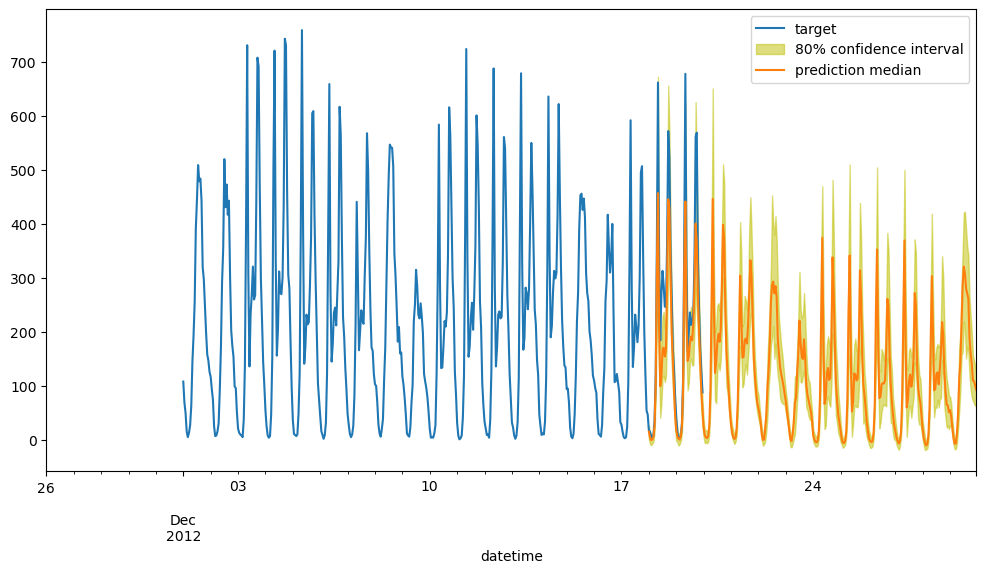

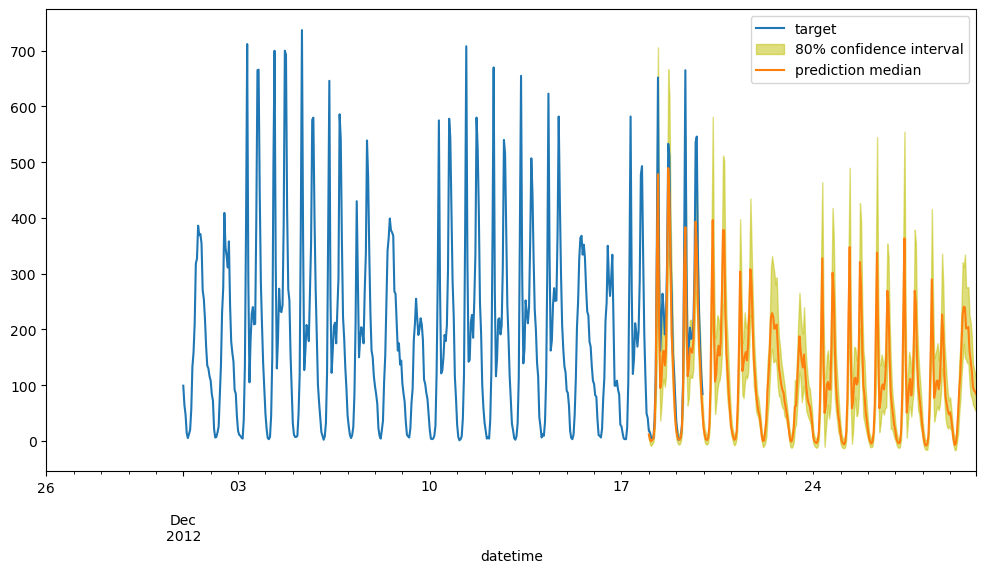

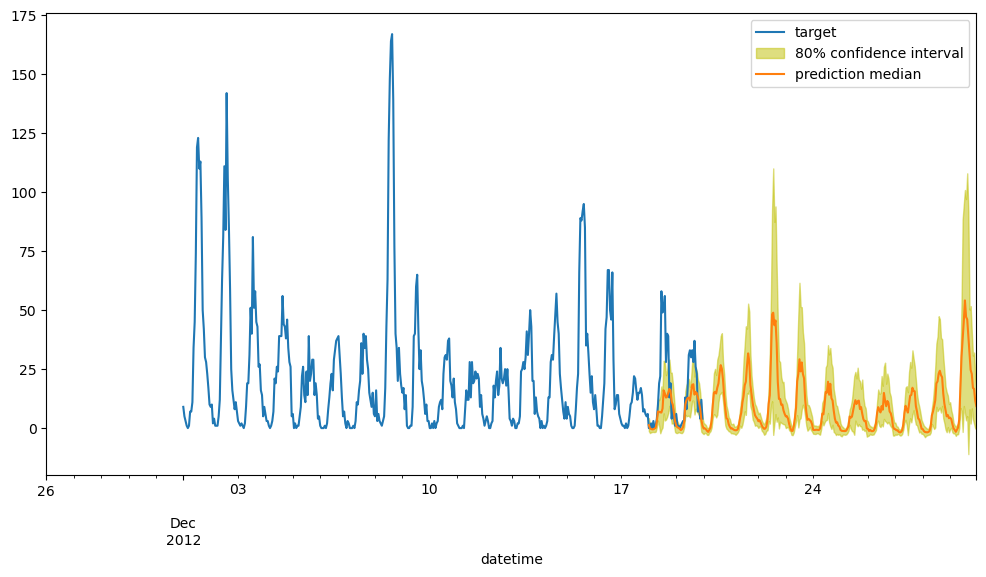

In [19]:
for k in range(len(list_of_df)):
    # print (-prediction_length-context_length) #120 = 72+48
    plt.figure(figsize=(12,6))
    
    time_series_test[k][-prediction_length-context_length:].plot(label='target')
    
    p10 = list_of_df[k]['0.1']
    p90 = list_of_df[k]['0.9']
    plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
    list_of_df[k]['0.5'].plot(label='prediction median')
    plt.legend()
    plt.show()

In [20]:
predict_window=[]

In [21]:
for i,x in df_test.groupby([df_test.index.year, df_test.index.month]):
    predict_window.append(x.index.min()-datetime.timedelta(hours=1))

In [22]:
predict_window

[Timestamp('2011-01-19 23:00:00'),
 Timestamp('2011-02-19 23:00:00'),
 Timestamp('2011-03-19 23:00:00'),
 Timestamp('2011-04-19 23:00:00'),
 Timestamp('2011-05-19 23:00:00'),
 Timestamp('2011-06-19 23:00:00'),
 Timestamp('2011-07-19 23:00:00'),
 Timestamp('2011-08-19 23:00:00'),
 Timestamp('2011-09-19 23:00:00'),
 Timestamp('2011-10-19 23:00:00'),
 Timestamp('2011-11-19 23:00:00'),
 Timestamp('2011-12-19 23:00:00'),
 Timestamp('2012-01-19 23:00:00'),
 Timestamp('2012-02-19 23:00:00'),
 Timestamp('2012-03-19 23:00:00'),
 Timestamp('2012-04-19 23:00:00'),
 Timestamp('2012-05-19 23:00:00'),
 Timestamp('2012-06-19 23:00:00'),
 Timestamp('2012-07-19 23:00:00'),
 Timestamp('2012-08-19 23:00:00'),
 Timestamp('2012-09-19 23:00:00'),
 Timestamp('2012-10-19 23:00:00'),
 Timestamp('2012-11-19 23:00:00'),
 Timestamp('2012-12-19 23:00:00')]

In [23]:
for t in target_values:
    df_test[t] = np.nan

In [24]:
df_test.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,registered,casual
datetime,,,,,,,,,,,
2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,NaN,NaN,NaN
2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,NaN,NaN,NaN
2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,NaN,NaN,NaN
2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,NaN,NaN,NaN
2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,NaN,NaN,NaN


In [25]:
for window in predict_window:
    print(window)
    # If trained with categories, we need to send corresponding category for each training set
    # But in this case
    for i in range(len(target_values)):
        list_of_df = predictor.predict([time_series_test[i][:window]],
                                      cat=[i] if with_categories else None)
        
        df_tmp = list_of_df[0]
        df_tmp.index.name = 'datetime'
        df_tmp.columns = ['0.1', target_values[i],'0.9']
        df_test.update(df_tmp[target_values[i]])

2011-01-19 23:00:00
2011-02-19 23:00:00
2011-03-19 23:00:00
2011-04-19 23:00:00
2011-05-19 23:00:00
2011-06-19 23:00:00
2011-07-19 23:00:00
2011-08-19 23:00:00
2011-09-19 23:00:00
2011-10-19 23:00:00
2011-11-19 23:00:00
2011-12-19 23:00:00
2012-01-19 23:00:00
2012-02-19 23:00:00
2012-03-19 23:00:00
2012-04-19 23:00:00
2012-05-19 23:00:00
2012-06-19 23:00:00
2012-07-19 23:00:00
2012-08-19 23:00:00
2012-09-19 23:00:00
2012-10-19 23:00:00
2012-11-19 23:00:00
2012-12-19 23:00:00


In [26]:
df_test.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,registered,casual
datetime,,,,,,,,,,,
2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,13.338977,12.230879,0.917219
2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,4.755291,4.938257,0.279129
2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,1.359585,1.357715,0.197672
2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,1.183345,1.499469,0.418141
2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,0.775891,1.073640,-0.110104


In [27]:
df_test.tail()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,registered,casual
datetime,,,,,,,,,,,
2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,312.860291,297.183044,13.356043
2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,204.543793,199.738876,10.744752
2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,153.084961,135.785797,9.271291
2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,99.434814,93.255310,7.342756
2012-12-31 23:00:00,1,0,1,1,10.66,13.635,65,8.9981,66.709656,64.551949,5.344893


In [28]:
def adjust_count(x):
    if x<0:
        return 0
    else:
        return x

In [29]:
df_test['count'] = df_test['count'].map(adjust_count)

In [80]:
# Store the results
if with_categories:
    df_test[['count']].to_csv('prediction-with-categories.csv', index=True, index_label='datetime')
else:
    df_test[['count']].to_csv('prediction.csv',index=True, index_label='datetime')
    

In [81]:
# Delete the endpoint after completing
predictor.delete_endpoint()